In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA


Datos de los gases de efecto invernadero Globales (datos de NOAA) 

- <b>Ref</b>: Dr. Pieter Tans, NOAA/GML (gml.noaa.gov/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

https://gml.noaa.gov/ccgg/trends/data.html

In [2]:
def read_data_annual(file,gas):
    file_path=file
    df=pd.read_csv(file_path)
    df=df.set_index("year")
    df.index = pd.to_datetime(df.index,format='%Y')
    df.rename(columns={"mean": gas},inplace=True)
    return df

def read_data_monthly(file,gas):
    file_path=file
    df=pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df=df.set_index("date")
    df.drop("year",axis=1,inplace=True)
    df.drop("month",axis=1,inplace=True)
    df.drop("decimal",axis=1,inplace=True)
    
    if gas == "CO2":
        df.rename(columns={"average": gas},inplace=True) 
        df.drop("trend",axis=1,inplace=True)
    else:
        df.rename(columns={"average": gas,"average_unc":"unc"},inplace=True) 
        df.drop("trend",axis=1,inplace=True)
        df.drop("trend_unc",axis=1,inplace=True)
    return df

In [3]:
# Leemos los ficheros y modificamos las tablas para crearlas como nosotros queremos
data_CO2_mensual=read_data_monthly("tablas_ini/NOAAdata_CO2_monthly.csv","CO2")
data_CO2_anual=read_data_annual("tablas_ini/NOAAdata_CO2_annual.csv","CO2")

data_N2O_mensual=read_data_monthly("tablas_ini/NOAAdata_N2O_monthly.csv","N2O")
data_N2O_anual=read_data_annual("tablas_ini/NOAAdata_N2O_annual.csv","N2O")

data_CH4_mensual=read_data_monthly("tablas_ini/NOAAdata_CH4_monthly.csv","CH4")
data_CH4_anual=read_data_annual("tablas_ini/NOAAdata_CH4_annual.csv","CH4")

data_SF6_mensual=read_data_monthly("tablas_ini/NOAAdata_SF6_monthly.csv","SF6")
data_SF6_anual=read_data_annual("tablas_ini/NOAAdata_SF6_annual.csv","SF6")

In [4]:
# Unimos todas las tablas
data_anual = pd.concat([data_CO2_anual, data_N2O_anual,data_CH4_anual,data_SF6_anual], axis=1)
data_mensual = pd.concat([data_CO2_mensual, data_N2O_mensual,data_CH4_mensual,data_SF6_mensual], axis=1)


In [5]:
# Extraemos de la fecha por un lado los meses y por otro los años, guardamos la información de dos nuevas columnas
data_month=data_mensual.reset_index()
data_anual_temp=data_anual.reset_index()

data_month['month'] = data_month['date'].dt.month
data_month['year'] = data_month['date'].dt.year

data_anual_temp['año'] = data_anual_temp['year'].dt.year

data_month=data_month.set_index("date")
# data_temp=data_anual.set_index("year")

#### Estadística de los datos

In [6]:
# estadistica de los datos
data_anual.describe()

,CO2,unc,N2O,unc,CH4,unc,SF6,unc
count,41.000000,4.100000e+01,20.000000,20.000000,37.000000,37.000000,23.000000,23.000000
mean,371.525854,1.000000e-01,324.013500,0.126000,1769.115676,0.599459,6.923478,0.003522
std,21.880138,1.405019e-17,5.273355,0.013139,57.565462,0.089503,1.896033,0.001039
min,338.910000,1.000000e-01,316.360000,0.100000,1644.680000,0.420000,4.210000,0.002000
25%,354.050000,1.000000e-01,319.592500,0.120000,1736.490000,0.540000,5.340000,0.003000
50%,368.960000,1.000000e-01,323.700000,0.125000,1773.360000,0.580000,6.750000,0.004000
75%,388.760000,1.000000e-01,328.365000,0.140000,1803.110000,0.660000,8.415000,0.004000
max,412.440000,1.000000e-01,333.030000,0.150000,1879.100000,0.810000,10.270000,0.006000


In [7]:
# estadistica de los datos
data_mensual.describe()

,CO2,N2O,unc,CH4,unc,SF6,unc
count,502.000000,249.000000,249.000000,459.000000,459.000000,291.000000,291.000000
mean,372.381733,324.388755,-0.196386,1769.844880,0.856209,6.978522,-0.266440
std,22.281381,5.407204,1.772035,60.633767,1.456974,1.964954,1.622506
min,337.050000,316.100000,-9.900000,1625.900000,-9.900000,4.000000,-9.900000
25%,354.000000,319.700000,0.100000,1736.650000,0.900000,5.245000,0.005000
50%,369.680000,324.100000,0.100000,1774.600000,1.000000,6.770000,0.006000
75%,390.265000,328.900000,0.100000,1807.150000,1.100000,8.615000,0.006000
max,416.080000,334.400000,0.200000,1900.500000,2.900000,10.690000,0.013000


array([[<AxesSubplot:title={'center':'CO2'}>,
        <AxesSubplot:title={'center':'N2O'}>],
       [<AxesSubplot:title={'center':'CH4'}>,
        <AxesSubplot:title={'center':'SF6'}>]], dtype=object)

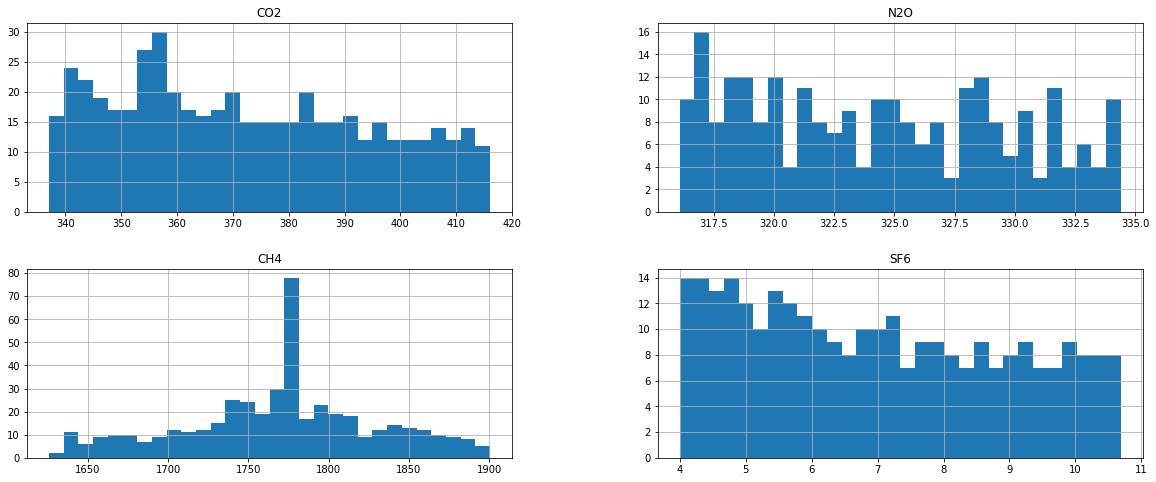

In [8]:
# Histograma de los datos
data_mensual.hist(column=["CO2","N2O","CH4","SF6"],bins=30, figsize=(20, 8))

#### Representación de los datos

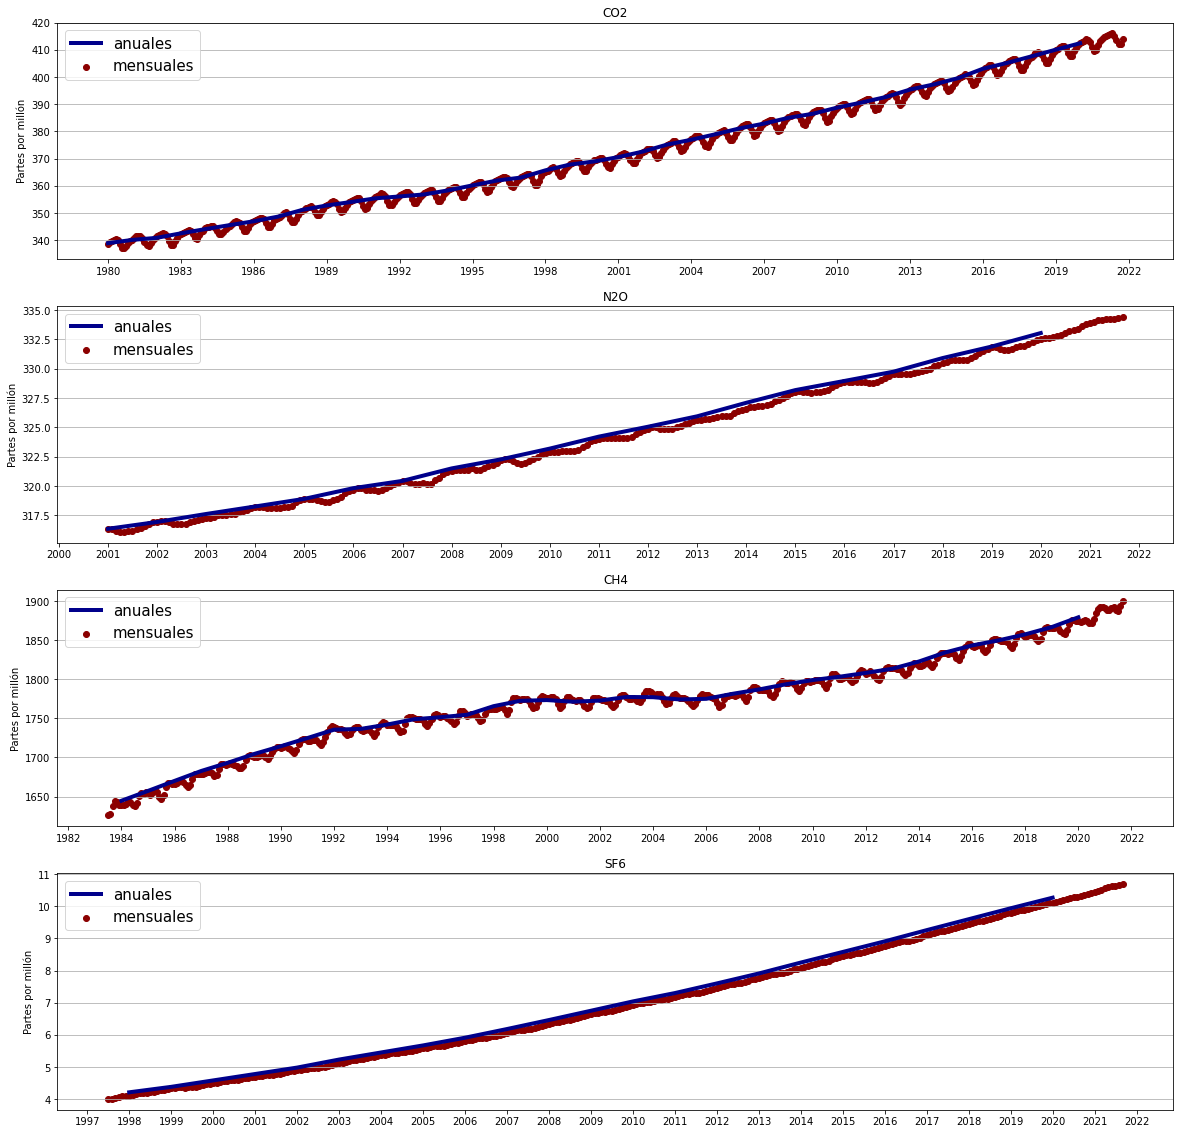

In [9]:
# Representación de los datos mensuales y anuales
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(20,20),sharex=False)

b=["CO2","N2O","CH4","SF6"]
year=[3,1,2,1]

for i in range(len(b)):

    ax[i].scatter(data_mensual.index,data_mensual[b[i]],c="darkred",label="mensuales")
    ax[i].plot(data_anual.index,data_anual[b[i]],c="darkblue",lw=4,label="anuales")

    ax[i].set_title(b[i])
    ax[i].yaxis.grid()
    ax[i].set_ylabel('Partes por millón')
    ax[i].legend(fontsize=15, loc="upper left")

    ax[i].xaxis.set_major_locator(mdates.YearLocator(year[i]))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[i].tick_params(axis='x', rotation=0)

#### Distribución de los datos

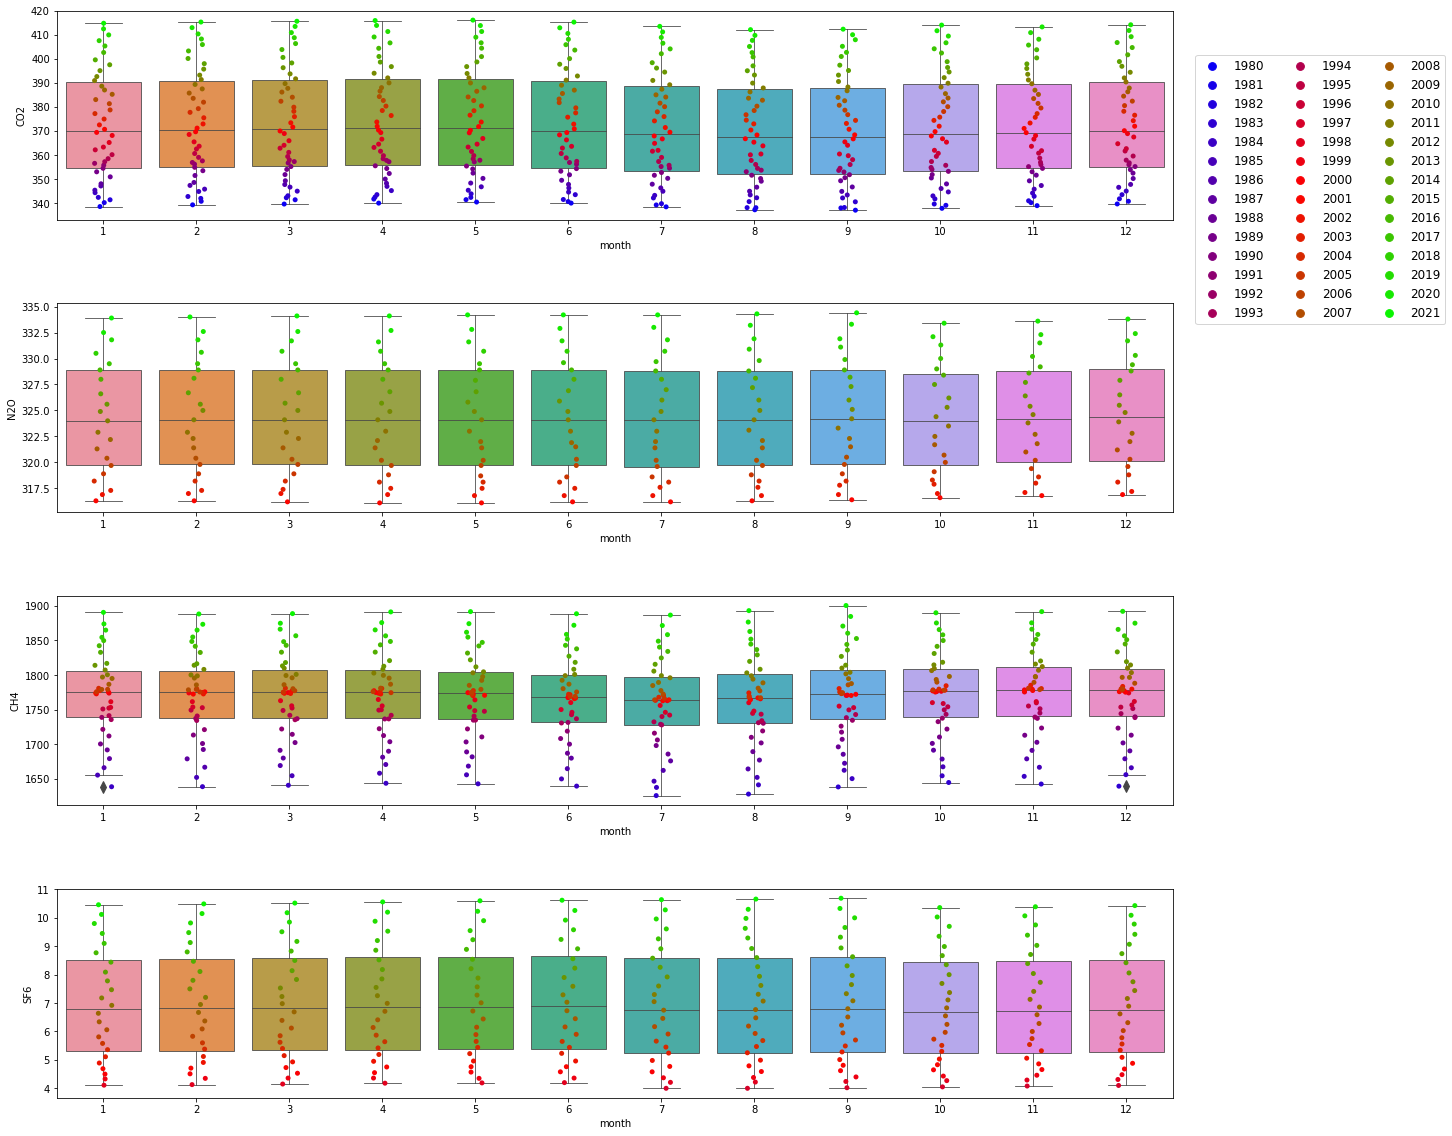

In [10]:
# Boxplot de los datos de cada gas para cada mes + scatterplot de los datos mensuales
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(20,20),sharex=False)
fig.subplots_adjust(hspace=0.4, wspace=0.2)

a=["CO2","N2O","CH4","SF6"]

for i in range(len(a)):
    sns.stripplot(x=data_month["month"], y=data_month[a[i]],hue=data_month["year"],ax=ax[i],size=5,jitter=True,
                 palette='brg')
    sns.boxplot(x=data_month["month"], y=data_month[a[i]],ax=ax[i],fliersize=8,linewidth=0.8)

    handles, labels = ax[0].get_legend_handles_labels()
    ax[i].legend('',frameon=False)
    ax[0].legend(handles, labels,loc=(1.02,-0.5),fontsize=12,ncol=3)

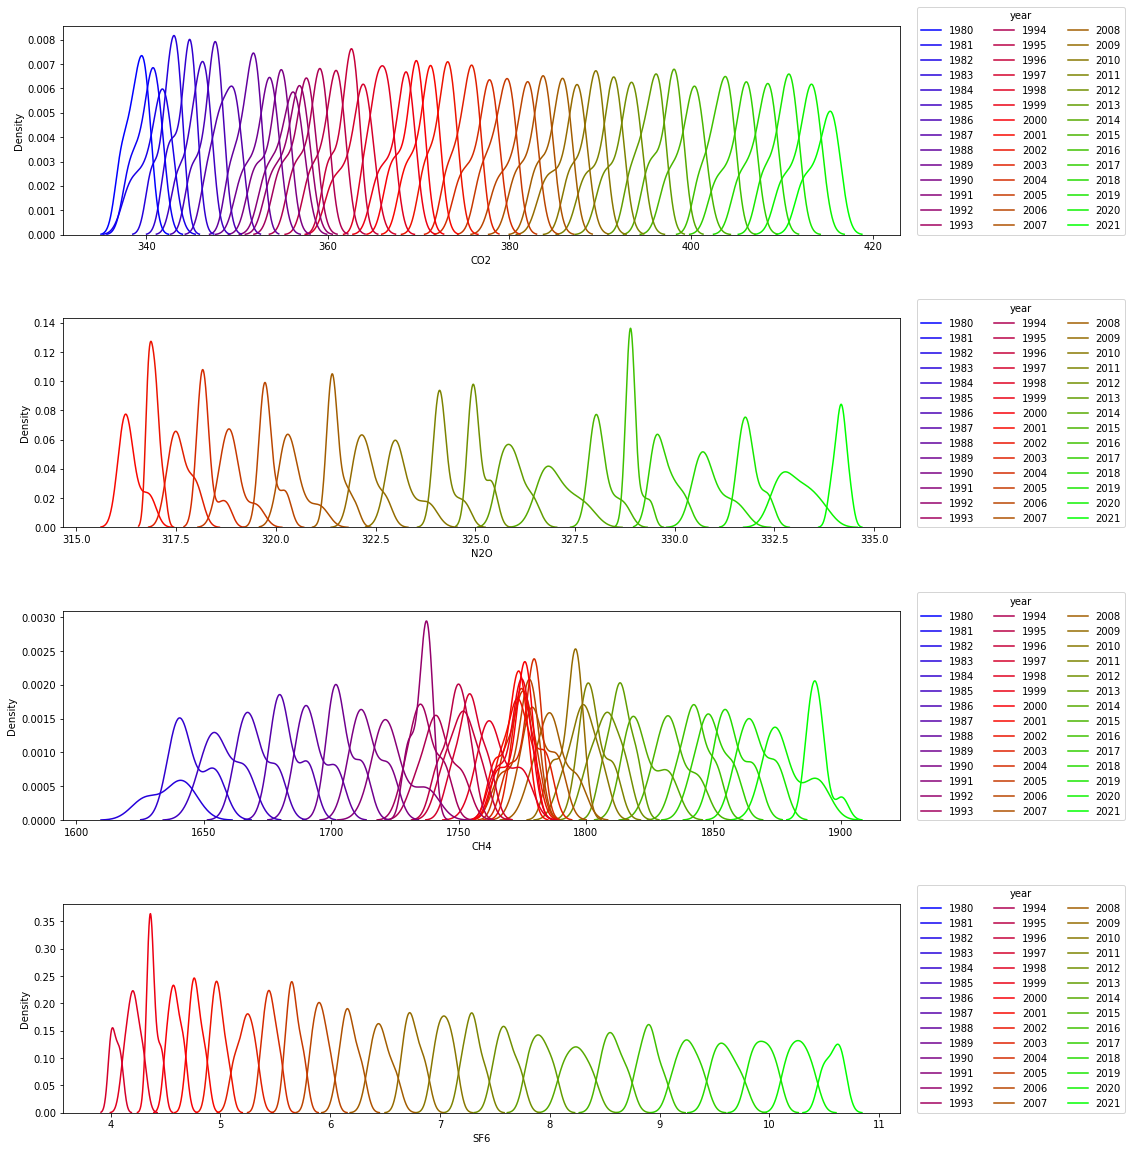

In [11]:
# Representación de la distrubución (KDE) por años  de los gases medidos cada mes
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

a=["CO2","N2O","CH4","SF6"]

for i in range(len(a)):
    ax = fig.add_subplot(4, 1, i+1)
    plot=sns.kdeplot(x=data_month[a[i]].dropna(axis=0),hue=data_month["year"].dropna(axis=0),
                     palette='brg',ax=ax,warn_singular=False)
    sns.move_legend(ax, ncol=3, loc=(1.02,0))


#### Estudio de la estacionariedad

In [50]:
# Función en la que estimamos los diferentes parámetros y plots para hacer el estudio de la estacionaridad
def test_stacionary(df,gas,ventana,metodo):
     
    # Cálculo de las propiedades estadíscias móviles
    df_temp=df[["CO2","N2O","CH4","SF6"]]
    df_temp=df
    df_mov_avg=df_temp.rolling(ventana).mean()
    df_mov_std=df_temp.rolling(ventana).std()

    
    print("-- "+str(gas)+" --> "+str(metodo)+":\n")
    # Representación de los datos junto con la estadística móvil
    fig, ax1 = plt.subplots(1,1,figsize=(20,5))
    ax2=ax1.twinx()

    plot1=ax1.plot(df.index,df[gas],c='blue',label="datos mensuales",lw=3)
    plot2=ax1.plot(df_mov_avg.index,df_mov_avg[gas],"-",label="promedio",c="black",lw=3)
    plot3=ax2.plot(df_mov_std.index,df_mov_std[gas],"-",label="desviación std.",c="red",lw=3)
    ax1.set_title(str(gas)+" -- "+str(metodo))
    ax1.set_ylabel('Partes por millon')
    ax2.set_ylabel('Partes por millon')
    ax1.yaxis.grid()
    ax2.set_ylim((0,20))

    lns1 = plot1
    labs1 = [l.get_label() for l in lns1]
    lns2 = plot2+plot3
    labs2 = [l.get_label() for l in lns2]

    ax1.legend(lns1,labs1,loc=(1.05,0.8),fontsize=14, fancybox=True, shadow=True)
    ax2.legend(lns2,labs2,loc=(1.05,0.5),fontsize=14, fancybox=True, shadow=True)
    ax2.get_legend().set_title("Estadisticas móviles \n con ventana de "+str(ventana)+": \n",prop={'size':16})
    plt.show()
    
    # Cálculo de la media y desviación std en varias regiones de los datos
    X = df[gas].dropna(axis=0)
    
    split = int(len(X) / 4)
    X1, X2,X3,X4 = X[0:split],X[split:split*2],X[split*2:split*3], X[split*3:]
    mean1,mean2,mean3,mean4 = X1.mean(), X2.mean(), X3.mean(), X4.mean()
    std1,std2,std3,std4 = X1.std(), X2.std(),X3.std(), X4.std()
    print("\n-- Estimación de media y desviación std dividiendo los datos en 4 regiones:")
    print('mean1={:.3f}, mean2={:.3f}, mean3={:.3f}, mean4={:.3f}'.format(mean1, mean2,mean3, mean4))
    print('desv. std1={:.3f}, desv. std2={:.3f}, desv. std3={:.3f}, desv. std4={:.3f}'.format(std1, std2,
                                                                                              std3, std4))
    
    # Test de Dickey-Fuller:
    dftest = adfuller(df[gas].dropna(axis=0), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print("\n-- Test de Dickey-Fuller:")
    print(dfoutput)  

-- CO2 --> datos originales:



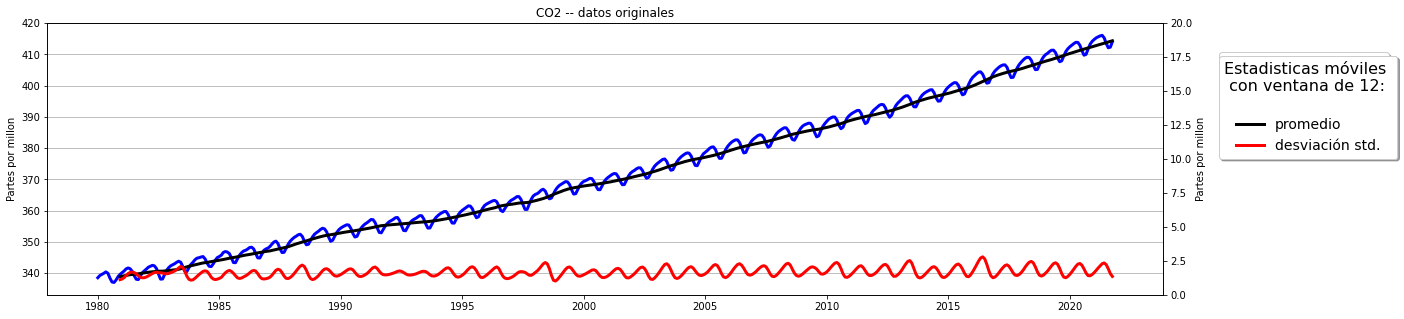


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=345.558, mean2=360.839, mean3=379.968, mean4=402.676
desv. std1=4.968, desv. std2=4.988, desv. std3=6.214, desv. std4=7.691

-- Test de Dickey-Fuller:
Test Statistic                   3.263791
p-value                          1.000000
#Lags Used                      18.000000
Number of Observations Used    483.000000
Critical Value (1%)             -3.443962
Critical Value (5%)             -2.867543
Critical Value (10%)            -2.569967
dtype: float64


In [52]:
# Estudio de la estacionaridad para los datos de CO2:
# fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,5),sharex=False)
test_stacionary(data_mensual,"CO2",12, "datos originales")

-- N2O --> datos originales:



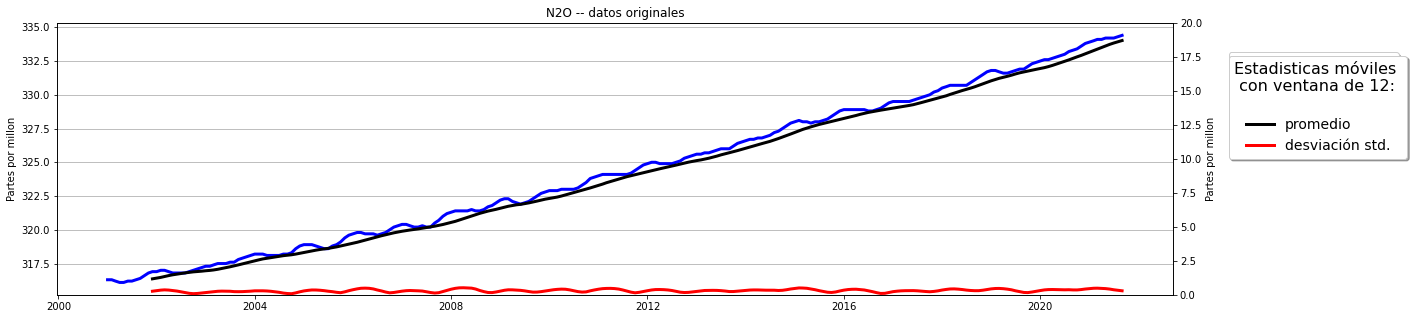


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=317.692, mean2=321.679, mean3=326.503, mean4=331.565
desv. std1=1.009, desv. std2=1.346, desv. std3=1.538, desv. std4=1.688

-- Test de Dickey-Fuller:
Test Statistic                   2.421504
p-value                          0.999020
#Lags Used                      13.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


In [53]:
# Estudio de la estacionaridad para los datos de N2O:
test_stacionary(data_mensual,"N2O",12, "datos originales")

-- CH4 --> datos originales:



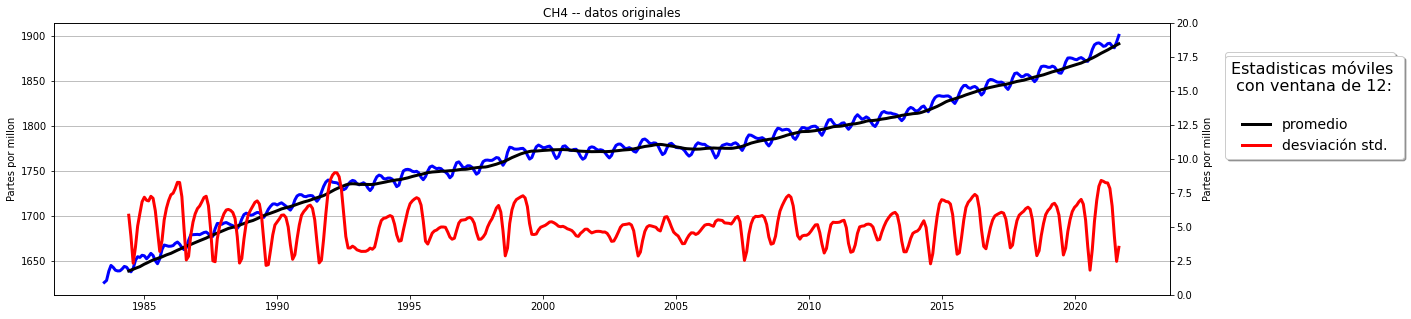


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=1689.102, mean2=1758.126, mean3=1784.698, mean4=1845.463
desv. std1=31.617, desv. std2=14.070, desv. std3=11.543, desv. std4=26.325

-- Test de Dickey-Fuller:
Test Statistic                   0.011126
p-value                          0.959443
#Lags Used                      16.000000
Number of Observations Used    442.000000
Critical Value (1%)             -3.445232
Critical Value (5%)             -2.868101
Critical Value (10%)            -2.570265
dtype: float64


In [54]:
# Estudio de la estacionaridad para los datos de CH4:
test_stacionary(data_mensual,"CH4",12, "datos originales")

-- SF6 --> datos originales:



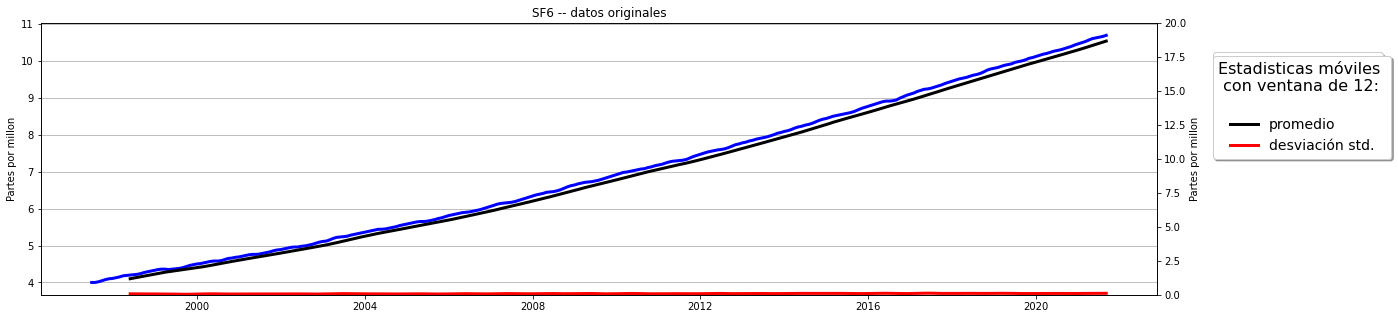


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=4.591, mean2=5.946, mean3=7.628, mean4=9.639
desv. std1=0.346, desv. std2=0.444, desv. std3=0.531, desv. std4=0.620

-- Test de Dickey-Fuller:
Test Statistic                   3.389398
p-value                          1.000000
#Lags Used                      15.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [55]:
# Estudio de la estacionaridad para los datos de SF6:
test_stacionary(data_mensual,"SF6",12, "datos originales")

** Ninguna de las series temporales son estacionarias. Se aprecia una clara tendencia ascendente dependiente del tiempo

#### Conversión serie en estacionaria

##### -- Eliminación tendencia:

Para eliminar la tendencia en primer lugar convertimos los datos en logarítmicos, una dez lo hemos hecho suavizamos los datos usando dos métodos diferentes:

<li> Sustraemos la média móvil usando una ventana de 12 </li>
<li> Sustraemos la média móvil ponderada exponencialmente con con un decaimiento en terminos de vida média de 12</li>

In [56]:
data_log=np.log(data_mensual[["CO2","N2O","CH4","SF6"]])

# Eliminamos la tendencia usando el logaritmo de los datos y sustrayendo la media móvil con 
# una ventana de 12

data_mov_avg=data_log.rolling(12).mean() # Cálculo de la medía móvil
data_diff_avg_mov=data_log-data_mov_avg # Sustraemos los datos

# Eliminamos la tendencia usandola média móvil ponderada exponencialmente con un decaimiento en terminos de vida 
# média de 12, ya que el estudio de estacionaridad es mejor.

data_mov_avg_exp=data_log.ewm(halflife=12).mean()
data_diff_avg_mov_exp=data_log-data_mov_avg_exp

-- CO2 --> eliminación tendencia con medía móvil:



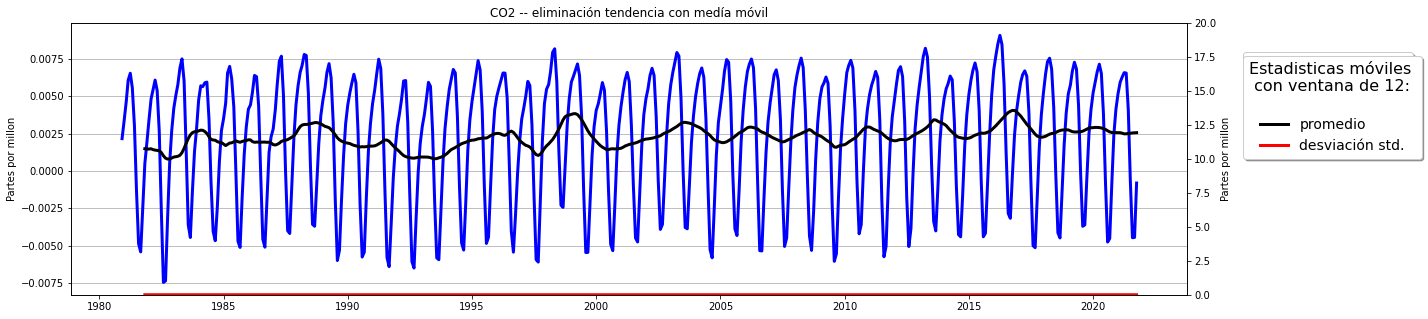


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=0.002, mean2=0.002, mean3=0.002, mean4=0.003
desv. std1=0.004, desv. std2=0.004, desv. std3=0.004, desv. std4=0.004

-- Test de Dickey-Fuller:
Test Statistic                  -4.691895
p-value                          0.000087
#Lags Used                      18.000000
Number of Observations Used    472.000000
Critical Value (1%)             -3.444281
Critical Value (5%)             -2.867683
Critical Value (10%)            -2.570042
dtype: float64


In [81]:
# Test de estacionalidad para CO2 usando la média móvil

test_stacionary(data_diff_avg_mov,"CO2",12,"eliminación tendencia con medía móvil") # Estudio de la estacionaridad

-- N2O --> eliminación tendencia con medía móvil:



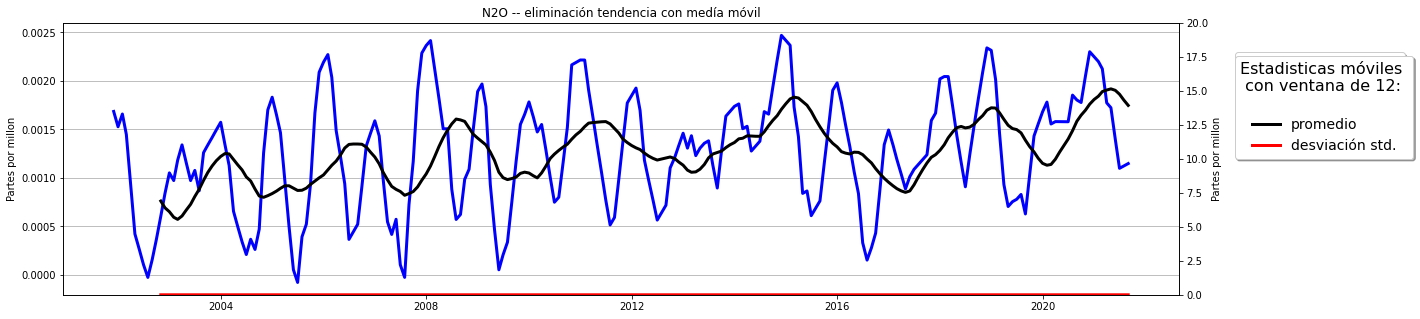


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=0.001, mean2=0.001, mean3=0.001, mean4=0.001
desv. std1=0.001, desv. std2=0.001, desv. std3=0.001, desv. std4=0.000

-- Test de Dickey-Fuller:
Test Statistic                  -4.611255
p-value                          0.000123
#Lags Used                      13.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


In [83]:
# Test de estacionalidad para N2O usando la média móvil

test_stacionary(data_diff_avg_mov,"N2O",12,"eliminación tendencia con medía móvil") # Estudio de la estacionaridad

-- CH4 --> eliminación tendencia con medía móvil:



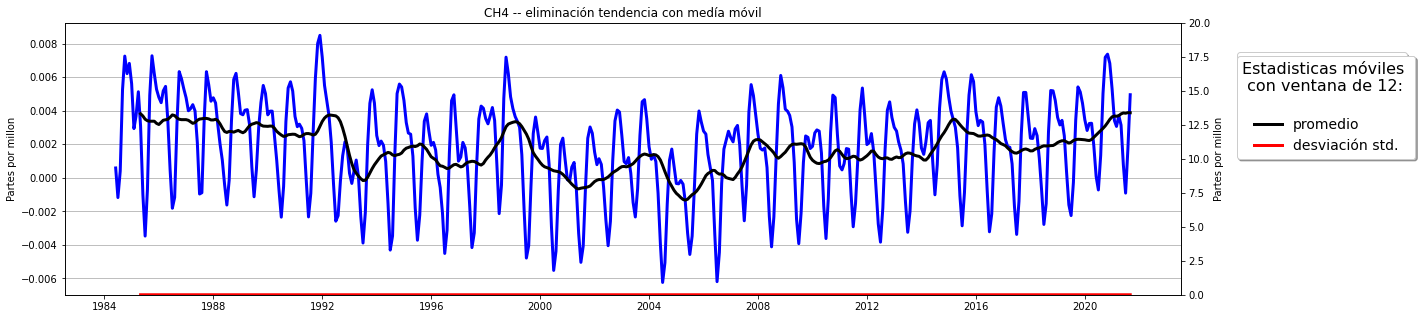


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=0.003, mean2=0.001, mean3=0.001, mean4=0.002
desv. std1=0.003, desv. std2=0.003, desv. std3=0.003, desv. std4=0.003

-- Test de Dickey-Fuller:
Test Statistic                  -2.576109
p-value                          0.098036
#Lags Used                      18.000000
Number of Observations Used    429.000000
Critical Value (1%)             -3.445685
Critical Value (5%)             -2.868301
Critical Value (10%)            -2.570371
dtype: float64


In [85]:
# Test de estacionalidad para CH4 usando la média móvil

test_stacionary(data_diff_avg_mov,"CH4",12,"eliminación tendencia con medía móvil") # Estudio de la estacionaridad

-- SF6 --> eliminación tendencia con medía móvil ponderada exponencialmente:



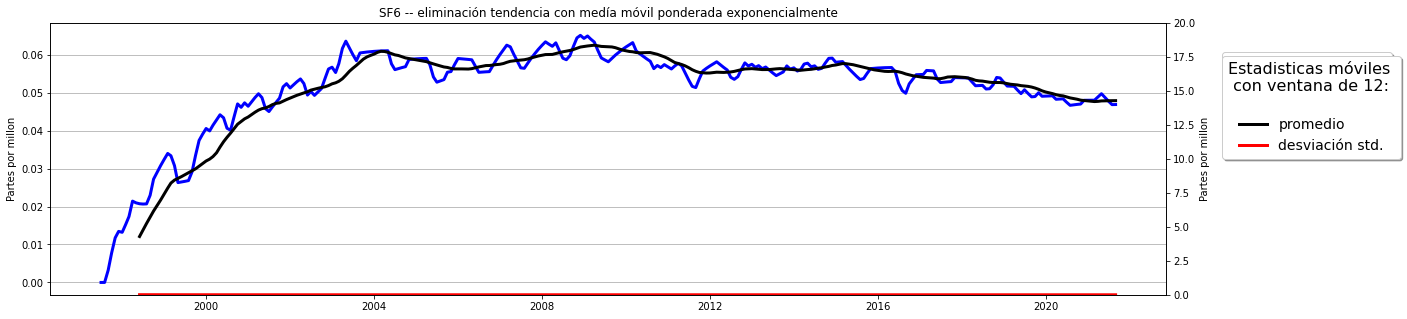


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=0.038, mean2=0.059, mean3=0.057, mean4=0.052
desv. std1=0.016, desv. std2=0.003, desv. std3=0.002, desv. std4=0.003

-- Test de Dickey-Fuller:
Test Statistic                  -2.781465
p-value                          0.060971
#Lags Used                      15.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [87]:
# Test de estacionalidad para SF6 usando la média móvil ponderada exponencialmente [hemos comprobado que en 
# este caso funciona mejor]

test_stacionary(data_diff_avg_mov_exp,"SF6",12,"eliminación tendencia con medía móvil ponderada exponencialmente")

##### -- Eliminación tendencia y estacionalidad:

En este caso vamos a intentar eliminar tanto la tendencia como la estacionalidad de los datos. Para ello volvemos a trabajar con los datos logarítmicos. Usamos la descomposición estacional usando los promedios móviles que proporciona la función <code>seasonal_decompose</code> de statsmodels.

In [75]:
# Función para estimar la descomposición de los datos en su tendencia y extacionalidad y estimar los parámetros
# y plots para hacer el estudio de la estacionaridad 

def test_stacionary_descompose(df,gas,ventana,metodo):
    print("-- "+str(gas)+" --> "+str(metodo)+":\n")
    # Calculo de la descomposición de los datos
    fig = plt.figure(figsize=(15,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    decomposition=seasonal_decompose(df[gas].dropna(axis=0))
    trend=decomposition.trend
    seasonal=decomposition.seasonal
    residual=decomposition.resid

    plt.subplot(411)
    plt.plot(df[gas],label="datos originales")
    plt.legend(loc=(1.01,0.5))
    plt.subplot(412)
    plt.plot(trend,label="Tendencia")
    plt.legend(loc=(1.01,0.5))
    plt.subplot(413)
    plt.plot(seasonal,label="Estacionalidad")
    plt.legend(loc=(1.01,0.5))
    plt.subplot(414)
    plt.plot(residual,label="Residuos")
    plt.legend(loc=(1.01,0.5))
    plt.show()
    
    
    # Cálculo de las propiedades estadíscias móviles
    df_temp=residual
    df_mov_avg=df_temp.rolling(ventana).mean()
    df_mov_std=df_temp.rolling(ventana).std()

    
    # Representación de los datos junto con la estadística móvil
    fig, ax1 = plt.subplots(1,1,figsize=(20,5))
    ax2=ax1.twinx()

    plot1=ax1.plot(residual,c='blue',label="datos mensuales",lw=3)
    plot2=ax1.plot(df_mov_avg,"-",label="promedio",c="black",lw=3)
    plot3=ax2.plot(df_mov_std,"-",label="desviación std.",c="red",lw=3)
    ax1.set_title(str(gas)+" -- "+str(metodo))
    ax1.set_ylabel('Partes por millon')
    ax2.set_ylabel('Partes por millon')
    ax1.yaxis.grid()
    ax2.set_ylim((0,20))

    lns1 = plot1
    labs1 = [l.get_label() for l in lns1]
    lns2 = plot2+plot3
    labs2 = [l.get_label() for l in lns2]

    ax1.legend(lns1,labs1,loc=(1.05,0.8),fontsize=14, fancybox=True, shadow=True)
    ax2.legend(lns2,labs2,loc=(1.05,0.3),fontsize=14, fancybox=True, shadow=True)
    ax2.get_legend().set_title("Estadisticas móviles \n con ventana de "+str(ventana)+": \n",prop={'size':16})
    plt.show()
    
    # Cálculo de la media y desviación std en varias regiones de los datos
    X = residual.dropna(axis=0)
    
    split = int(len(X) / 4)
    X1, X2,X3,X4 = X[0:split],X[split:split*2],X[split*2:split*3], X[split*3:]
    mean1,mean2,mean3,mean4 = X1.mean(), X2.mean(), X3.mean(), X4.mean()
    std1,std2,std3,std4 = X1.std(), X2.std(),X3.std(), X4.std()
    print("\n-- Estimación de media y desviación std dividiendo los datos en 4 regiones:")
    print('mean1={:.3f}, mean2={:.3f}, mean3={:.3f}, mean4={:.3f}'.format(mean1, mean2,mean3, mean4))
    print('desv. std1={:.3f}, desv. std2={:.3f}, desv. std3={:.3f}, desv. std4={:.3f}'.format(std1, std2,
                                                                                              std3, std4))
    
    # Test de Dickey-Fuller:
    dftest = adfuller(residual.dropna(axis=0), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print("\n-- Test de Dickey-Fuller:")
    print(dfoutput)
    return trend,seasonal,residual

-- CO2 --> elimación tendencia y estacionalidad usando descomposición de los datos:



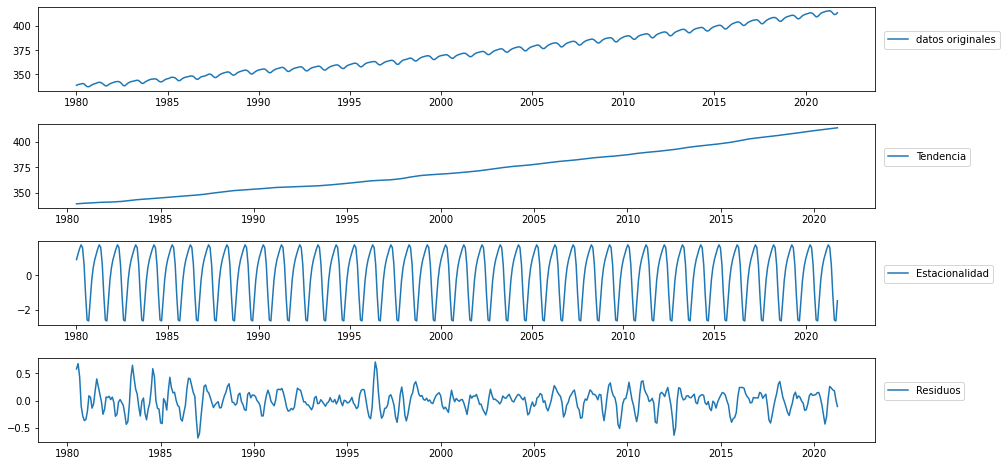

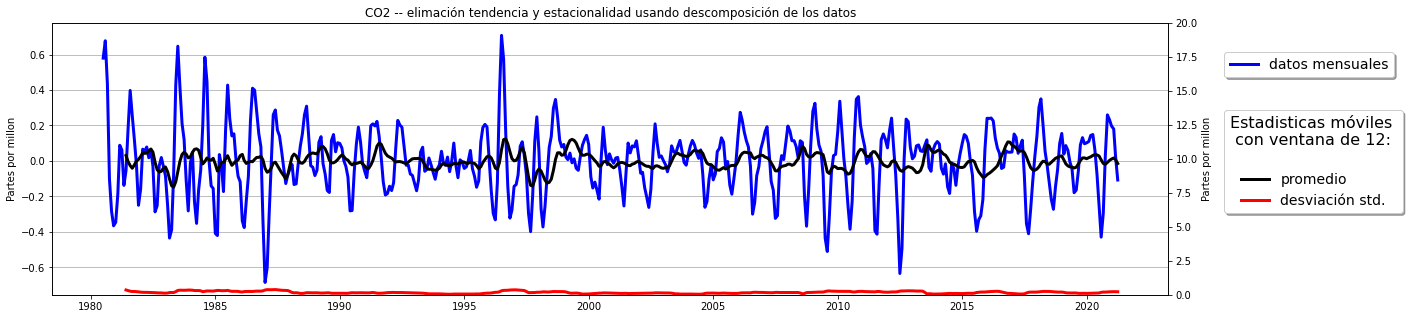


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=0.002, mean2=0.003, mean3=0.000, mean4=-0.002
desv. std1=0.248, desv. std2=0.171, desv. std3=0.164, desv. std4=0.181

-- Test de Dickey-Fuller:
Test Statistic                -8.102095e+00
p-value                        1.291636e-12
#Lags Used                     1.800000e+01
Number of Observations Used    4.710000e+02
Critical Value (1%)           -3.444310e+00
Critical Value (5%)           -2.867696e+00
Critical Value (10%)          -2.570049e+00
dtype: float64


In [76]:
# Estudio estacionaridad usando la descomposición de los datos
trend_CO2,seasonal_CO2,residual_CO2=test_stacionary_descompose(data_mensual,"CO2",12,"elimación tendencia y estacionalidad usando descomposición de los datos")

-- N2O --> elimación tendencia y estacionalidad usando descomposición de los datos:



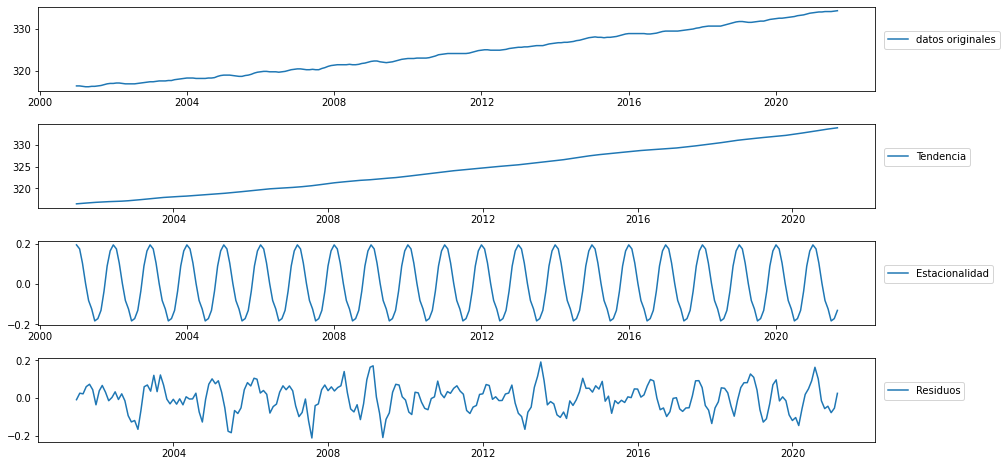

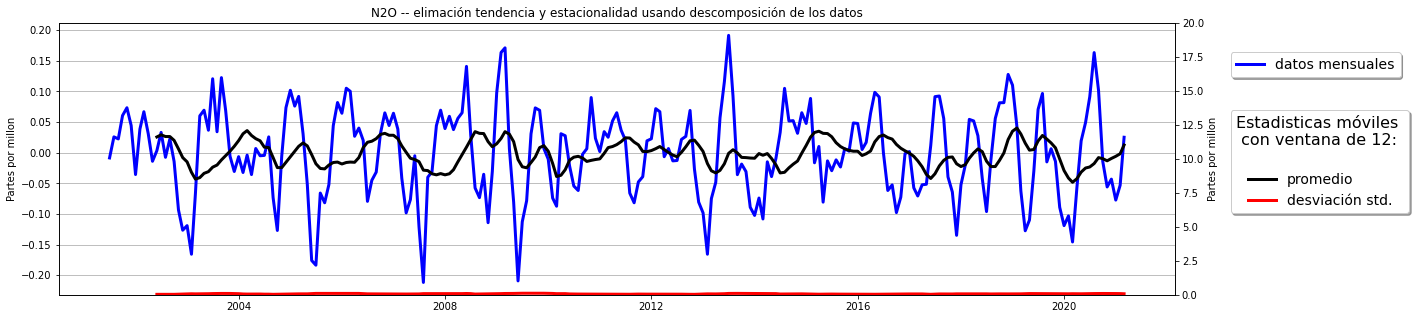


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=0.004, mean2=-0.003, mean3=0.001, mean4=-0.005
desv. std1=0.073, desv. std2=0.077, desv. std3=0.064, desv. std4=0.075

-- Test de Dickey-Fuller:
Test Statistic                -7.130682e+00
p-value                        3.524400e-10
#Lags Used                     1.000000e+01
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64


In [77]:
# Estudio estacionaridad usando la descomposición de los datos
trend_N2O,seasonal_N2O,residual_N2O=test_stacionary_descompose(data_mensual,"N2O",12,"elimación tendencia y estacionalidad usando descomposición de los datos")

-- CH4 --> elimación tendencia y estacionalidad usando descomposición de los datos:



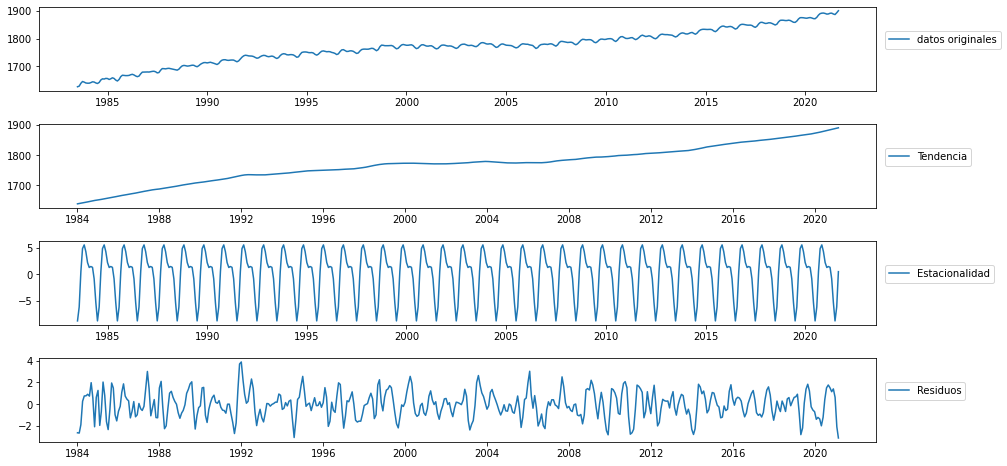

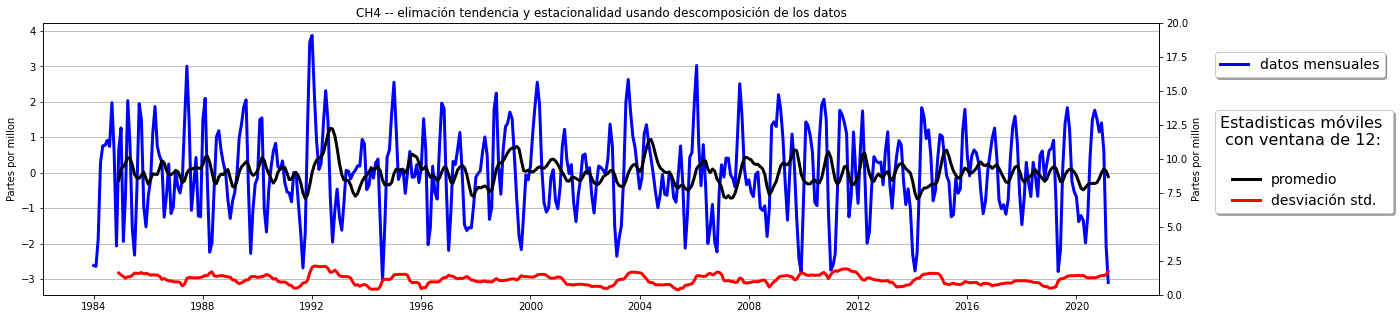


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=-0.004, mean2=0.010, mean3=0.003, mean4=-0.057
desv. std1=1.366, desv. std2=1.061, desv. std3=1.276, desv. std4=1.102

-- Test de Dickey-Fuller:
Test Statistic                -7.502339e+00
p-value                        4.221266e-11
#Lags Used                     1.600000e+01
Number of Observations Used    4.300000e+02
Critical Value (1%)           -3.445649e+00
Critical Value (5%)           -2.868285e+00
Critical Value (10%)          -2.570363e+00
dtype: float64


In [78]:
# Estudio estacionaridad usando la descomposición de los datos
trend_CH4,seasonal_CH4,residual_CH4=test_stacionary_descompose(data_mensual,"CH4",12,"elimación tendencia y estacionalidad usando descomposición de los datos")

-- SF6 --> elimación tendencia y estacionalidad usando descomposición de los datos:



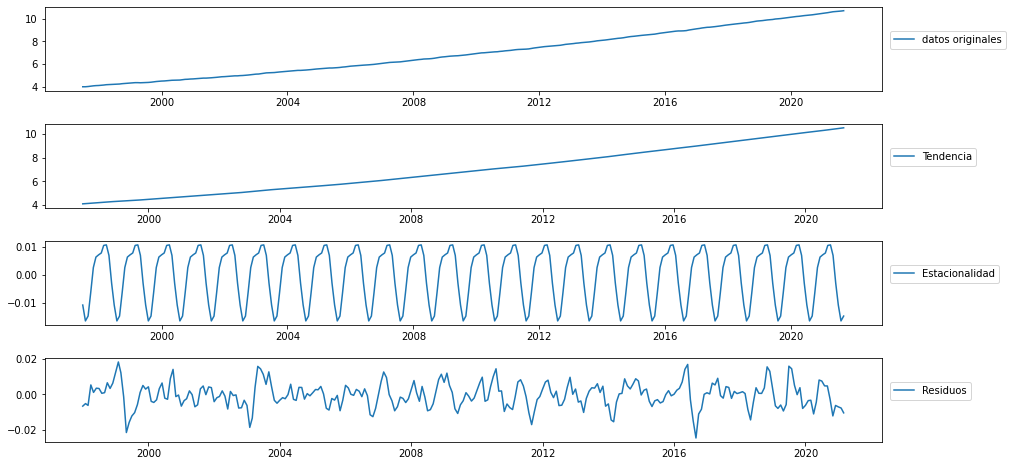

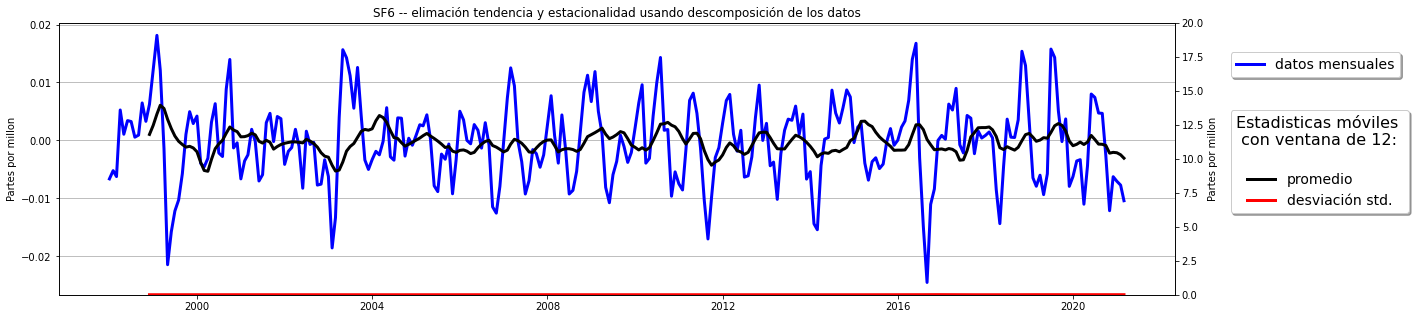


-- Estimación de media y desviación std dividiendo los datos en 4 regiones:
mean1=-0.000, mean2=-0.001, mean3=-0.000, mean4=-0.001
desv. std1=0.008, desv. std2=0.006, desv. std3=0.006, desv. std4=0.008

-- Test de Dickey-Fuller:
Test Statistic                -7.353580e+00
p-value                        9.913306e-11
#Lags Used                     1.100000e+01
Number of Observations Used    2.670000e+02
Critical Value (1%)           -3.455081e+00
Critical Value (5%)           -2.872427e+00
Critical Value (10%)          -2.572571e+00
dtype: float64


In [79]:
# Estudio estacionaridad usando la descomposición de los datos
trend_SF6,seasonal_SF6,residual_SF6=test_stacionary_descompose(data_mensual,"SF6",12,"elimación tendencia y estacionalidad usando descomposición de los datos")

| nivel de confianza estacionaridad datos | CO2 | N2O | CH4 | SF6 |
|:-------------------:|:---:|:---:|:---:|:---:|
| Datos sin tratar | No estacionario | No estacionario | No estacionario | No estacionario |
| Sustrayendo medía móvil | 99% | 99% | 90% | No estacionario |
| Sustrayendo medía móvil ponderada exponencialmente | 95% | No estacionario | No estacionario | 90% |
| Descomposición de los datos | 99% | 99% | 99% | 99% |